In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans
import shutil

from skimage import data
from skimage.io import imread, imshow

Para hacer más comprensible e intuitivo la clasificación de los individuos se asignará un nombre único a cada muestra para que se ajuste al funcionamiento en un entorno real.

In [9]:
def create_dir_tree(directory, names):
    '''
    Crea directorio con n muestras,
    '''
    if os.path.exists(directory):
        shutil.rmtree(directory) # borramos directorio y lurgo le creamos
        
    os.mkdir(directory)
        
    for name in names:
        sample = os.path.join(directory,name)
        os.mkdir(sample)

In [10]:
random_names = pd.read_csv('random_names.csv')
random_names = random_names['Names'][:len(os.listdir("CASIA-IrisV1"))]
random_names[:5]

0    Serenity
1    Cataleya
2      Andrew
3       Corey
4       Maite
Name: Names, dtype: object

In [11]:
new_dir = "CASIA-Iris"
create_dir_tree(new_dir,random_names)

In [12]:
def copy_samples(to_dir, from_dir):
    directories = os.listdir(to_dir) # nombres de las muestras
    i = 0
    k = 1
    for root, dirs, files in os.walk(from_dir):
        for file in files:
            if file.endswith(".bmp"):
                source = os.path.join(root, file)
                dest = os.path.join(to_dir,directories[i])
                shutil.copy(source, dest)
                if len(os.listdir(dest)) == 7:
                    i = i + 1
                    continue

In [13]:
copy_samples(new_dir, "CASIA-IrisV1")

In [14]:
# cambiamos nombre a las muestras
for root, dirs, files in os.walk(new_dir):
    for d in dirs:
        name = str(d)
        k = 1
        for i in os.listdir(os.path.join(new_dir,d)):
            os.rename(os.path.join(os.path.join(new_dir,d),i), os.path.join(os.path.join(new_dir,d),name + '_' + str(k)+'.bmp'))
            k += 1

In [15]:
def get_paths(directory):
    '''
    Devuelve la ruta relativa de las muestras .bmp
    '''
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".bmp"):
                paths.append(os.path.join(root, file))
    return paths

In [16]:
paths_casia = get_paths("CASIA-Iris")
original_samples = [cv2.imread(muestra,0) for muestra in paths_casia] # array de las muestras originales en b&w

In [17]:
paths_casia[:10]

['CASIA-Iris\\Adrianna\\Adrianna_1.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_2.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_3.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_4.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_5.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_6.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_7.bmp',
 'CASIA-Iris\\Aharon\\Aharon_1.bmp',
 'CASIA-Iris\\Aharon\\Aharon_2.bmp',
 'CASIA-Iris\\Aharon\\Aharon_3.bmp']

In [18]:
def testGenerator(images, target_size= (320,320)):
    for muestra in images:
        img = muestra / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [19]:
def saveResult(results, save_dir, names):
    '''
    Guarda los imágenes segmentadas resultado de la red preentrenada
    
    Parámetros:
    results -- resultado de la red preentrenada
    save_path -- ruta en la que se guardarán las muestras segmentadas
    name_path -- directorio del que cogeremos los nombres de las muestras
    '''
    dim = (320, 280) # dimensiones originales de las muestras del dataset
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
        
    os.mkdir(save_dir)
    for i,item in enumerate(results):
        img = item[:,:,0]
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        io.imsave(os.path.join(save_dir,names[i]),img)

In [20]:
from keras.models import load_model

model = load_model('Iris_unet_d5.h5')
# model.summary()

In [21]:
gen = testGenerator(original_samples)
results = model.predict(gen,verbose=1)

756/756 [==============================] - 1022s 1s/step


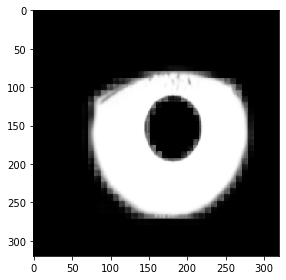

In [22]:
imshow(results[0][:,:,0]);

In [23]:
# guardamos la salida de la red en una nueva lista para que sea accesible
unet_outputs = []
dim = (320, 280) # dimensiones originales de las muestras del dataset
for r in results:
    img = r[:,:,0]
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    unet_outputs.append(img)

Es necesario reescalar ya que si no da error al aplicar el detector de Canny, el formato no es correcto

In [24]:
# reescalamos outputs a 0-1
unet_outputs = [cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 
                for img in unet_outputs]

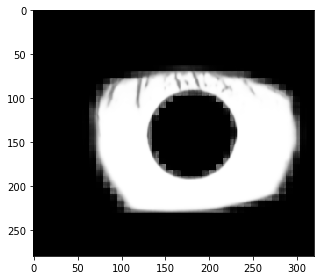

In [25]:
imshow(unet_outputs[7]);

### Aplicamos los operadores morfológicos

In [26]:
def morph_operator(images):
    enhanced = []
    for img in images:
        blur= cv2.GaussianBlur(img,(17,17),0)
        (thresh, binarized) = cv2.threshold(blur, 70, 255, cv2.THRESH_BINARY) # se binariza nuevament
        enhanced.append(binarized)
    return enhanced

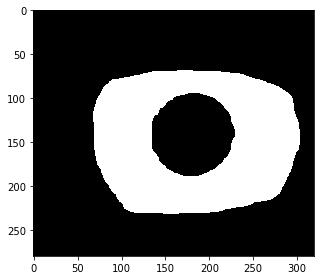

In [27]:
enhanced_outputs = morph_operator(unet_outputs)
imshow(enhanced_outputs[7]);
# enhanced_outputs

In [28]:
def canny_edges(images):
    canny_edges = []
    for img in images:
        edges = cv2.Canny(img, 10, 255)
        canny_edges.append(edges)
    
    return canny_edges

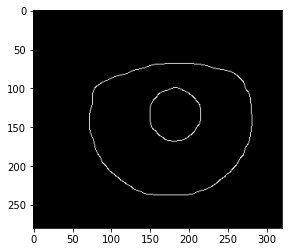

In [29]:
edged_outputs = canny_edges(enhanced_outputs)
plt.imshow(edged_outputs[0],"gray");

In [30]:
from skimage import data
from skimage.transform import (hough_line, hough_line_peaks, hough_circle, hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from matplotlib import cm
from time import time

In [31]:
def draw_circles(img, cx, cy, radii):
    '''
    A partir de los centros y el radio detectados dibuja el iris sobre la imagen que se le
    pasa como parámetro.
    '''
    image = img
    pupil = cv2.circle(image,(cx[0],cy[0]), radii[0], (255, 0, 0), 2)
    iris = cv2.circle(image,(cx[1],cy[1]), radii[1], (255, 0, 0), 2)
    return image

In [32]:
def get_circles(roi,gray_img):
    hough_radii = np.arange(20, 80) # pupila por defecto
    if roi  == "iris":
        hough_radii = np.arange(90, 160) # rango del iris
    
    hough_res = hough_circle(gray_img, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1) 
#     print(f"center of {borde}: ", (cx[0],cy[0]))
#     print(f"radius of {borde}: ", radii[0])
    
    return [cx[0], cy[0], radii[0]]

In [33]:
# EJECUTAR UNA VEZ QUE TARDA MUCHO!!!
def get_centers_radius(canny_images, original_images):
    boundaries = [] # contiene los bordes límbico y pupilar
    centers = [] # contiene centros y radio de la pupila
    i = 0
    tiempo_inicial = time()
    
    for img in canny_images:
        gray_img= img
        pupil_coord = get_circles("pupil",gray_img)
        iris_coord = get_circles("iris",gray_img)
        cx, cy, radius = list(zip(pupil_coord, iris_coord))
        
        # guardamos centros y radios
        boundaries.append(draw_circles(original_images[i], cx, cy, radius))
        data = {'pupil':pupil_coord,
                'iris':iris_coord}
        centers.append(data)
        
        i = i+1
    tiempo_final = time()
    
    print(f'DONE!, time elapsed:{tiempo_final-tiempo_inicial}')
    
    return boundaries, centers


In [34]:
boundaries, centers = get_centers_radius(edged_outputs, original_samples)

DONE!, time elapsed:716.9568252563477


In [35]:
boundaries[0]

array([[176, 166, 170, ..., 187, 180, 169],
       [170, 169, 173, ..., 185, 181, 179],
       [177, 165, 173, ..., 198, 187, 169],
       ...,
       [154, 155, 155, ..., 169, 178, 199],
       [159, 148, 154, ..., 170, 177, 192],
       [153, 154, 150, ..., 172, 171, 189]], dtype=uint8)

In [36]:
centers[0]

{'pupil': [182, 134, 33], 'iris': [176, 135, 105]}

### Normalización

In [37]:
pupil_centers = [center['pupil'] for center in centers]
pupil_centers[:10]

[[182, 134, 33],
 [173, 138, 35],
 [174, 120, 35],
 [183, 122, 37],
 [177, 145, 35],
 [179, 133, 36],
 [154, 131, 33],
 [181, 141, 47],
 [184, 139, 45],
 [172, 155, 44]]

In [38]:
def iris_normalization(boundaries,centers):
    normalized = []
    cent=0
    for img in boundaries:
#         img = normalized[name]
        #load pupil centers and radius of inner circles
        center_x = centers[cent][0]
        center_y = centers[cent][1]
        radius_pupil=int(centers[cent][2])
        
        iris_radius = 53 # width of space between inner and outer boundary
    
        #define equally spaced interval to iterate over
        nsamples = 360
        samples = np.linspace(0,2*np.pi, nsamples)[:-1]
        polar = np.zeros((iris_radius, nsamples))
        for r in range(iris_radius):
            for theta in samples:
                #get x and y for values on inner boundary
                x = (r+radius_pupil)*np.cos(theta)+center_x
                y = (r+radius_pupil)*np.sin(theta)+center_y
                x=int(x)
                y=int(y)
                try:
                #convert coordinates
                    polar[r][int((theta*nsamples)/(2*np.pi))] = img[y][x]
                except IndexError: #ignores values which lie out of bounds
                    pass
                continue
        res = cv2.resize(polar,(512,64))
        normalized.append(res)
        cent+=1
    print('DONE!')
    return normalized #returns a list of 64x512 normalized images

In [39]:
normalized_outputs = iris_normalization(boundaries,pupil_centers)

DONE!


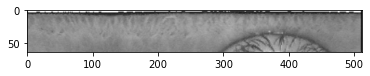

In [40]:
plt.imshow(normalized_outputs[0],"gray");

In [41]:
from skimage import exposure
def crop_and_ecualization(normalized):
    enhanced = []
    for img in normalized:
        h,w = img.shape
        roi = img[5:h, 0:int(512/2)]
        roi_enhanced = exposure.equalize_hist(roi)
        enhanced.append(roi_enhanced)
    print("DONE!")
    
    return enhanced

In [42]:
normalized_outputs = crop_and_ecualization(normalized_outputs)

DONE!


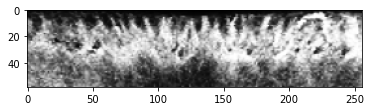

In [43]:
plt.imshow(normalized_outputs[0],"gray");

In [44]:
new_dir = "CASIA-Polar"
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)

create_dir_tree(new_dir,random_names)

In [45]:
names = os.listdir(new_dir)
paths = [os.path.join(new_dir, d) for d in names]
paths[:10]

['CASIA-Polar\\Adrianna',
 'CASIA-Polar\\Aharon',
 'CASIA-Polar\\Aidan',
 'CASIA-Polar\\Aiza',
 'CASIA-Polar\\Aleah',
 'CASIA-Polar\\Alice',
 'CASIA-Polar\\Alvin',
 'CASIA-Polar\\Amayah',
 'CASIA-Polar\\Amberly',
 'CASIA-Polar\\Aminata']

In [46]:
i = 0
k = 1
for file in normalized_outputs:
    dest = paths[i]
    io.imsave(os.path.join(dest,names[i] +'_'+ str(k) + '.bmp'),file)
    if len(os.listdir(dest)) == 7:
        i = i + 1
        k = 1
        continue
    k = k + 1

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [47]:
from pathlib import Path

# cogemos nombres de las imágenes .bmp
image_files = []

for root, dirs, files in os.walk(new_dir):
    for file in files:
        if file.endswith(".bmp"):
            image_files.append(file)
            
# cogemos las clases a las que pertenece cada .bmp
classes = []           
for name in names:
    for i in range(7):
        classes.append(name)
x_pupil, y_pupil, r_pupil =[], [], []
x_iris, y_iris, r_iris =[],[],[]
for i in centers:
    x_pupil.append(i['pupil'][0])
    y_pupil.append(i['pupil'][1])
    r_pupil.append(i['pupil'][2])
    x_iris.append(i['iris'][0])
    y_iris.append(i['iris'][1])
    r_iris.append(i['iris'][2])


In [48]:
data = {'image': image_files,
       'pupil x_center':x_pupil,
       'pupil y_center':y_pupil,
       'pupil radius': r_pupil,
       'iris x_center': x_iris,
       'iris y_center': y_iris,
       'iris radius':r_iris,
       'class': classes}
df = pd.DataFrame(data)[['image','pupil x_center','pupil y_center','pupil radius','iris x_center', 'iris y_center','iris radius',"class"]] 

df[10:20]

,image,pupil x_center,pupil y_center,pupil radius,iris x_center,iris y_center,iris radius,class
10,Aharon_4.bmp,194,134,47,197,137,114,Aharon
11,Aharon_5.bmp,157,138,47,130,138,92,Aharon
12,Aharon_6.bmp,168,137,48,172,133,118,Aharon
13,Aharon_7.bmp,172,132,48,176,126,118,Aharon
14,Aidan_1.bmp,185,148,39,187,150,111,Aidan
15,Aidan_2.bmp,168,146,36,150,153,93,Aidan
16,Aidan_3.bmp,176,143,39,178,147,111,Aidan
17,Aidan_4.bmp,176,147,37,159,159,91,Aidan
18,Aidan_5.bmp,170,163,36,152,175,90,Aidan
19,Aidan_6.bmp,171,172,34,174,171,112,Aidan


In [49]:
df.to_csv("iris_datav1.csv")